## A/A-тесты

А/А-тестирование мобильного приложения. Необходимо посчитать результаты A/A-теста, проверяя метрику качества FPR (False Positive Rate), будем проверять на конверсии в покупку. Известно, что сплит-система сломана. Требуется проверить утверждение о поломке и найти ее причины, если сплит-система действительно сломана.

In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv('hw_aa.csv', sep=';')
df.head()

,Unnamed: 0,uid,experimentVariant,version,purchase
0,1,c4ca4238a0b923820dcc509a6f75849b,1,v2.8.0,0
1,2,c81e728d9d4c2f636f067f89cc14862c,0,v2.9.0,0
2,3,eccbc87e4b5ce2fe28308fd9f2a7baf3,1,v2.9.0,0
3,4,a87ff679a2f3e71d9181a67b7542122c,1,v2.8.0,0
4,5,e4da3b7fbbce2345d7772b0674a318d5,1,v2.8.0,0


In [3]:
df.dtypes

Unnamed: 0            int64
uid                  object
experimentVariant     int64
version              object
purchase              int64
dtype: object

Функция для расчета теста:

In [5]:
def aa_test(
    data_column_1, 
    data_column_2,
    sim = 1000,  #количество симуляций
    n_s = 1000, #объем подвыборки
    alpha = 0.05
):
    res = []
    for i in range(sim):
        s1 = data_column_1.sample(n_s, replace = False).values
        s2 = data_column_2.sample(n_s, replace = False).values
        res.append(stats.ttest_ind(s1, s2, equal_var = False)[1]) # сохраняем pvalue
    
    # Визуализация
    plt.hist(res, bins = 50)
    plt.xlabel('pvalues')
    plt.ylabel('frequency')
    plt.show()
    
    return sum(np.array(res) < alpha) / sim

Расчет для df:

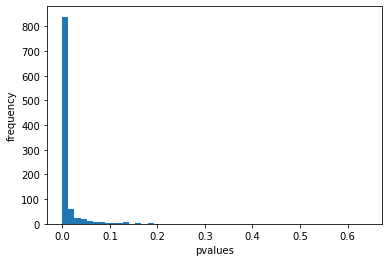

0.937

In [6]:
aa_test(df[df.experimentVariant == 1].purchase, df[df.experimentVariant == 0].purchase)

Доля ложноположительных оценок (FPR) намного больше 0,05, значит, сплит-система работает некорректно. 

Если предположить, что причиной поломки являются различия в работе разных версиий приложения, нужно посмотреть на конверсии в покупку по версиям:

In [7]:
df.groupby(['experimentVariant','version'], as_index=False).agg({'purchase':'mean'})

,experimentVariant,version,purchase
0,0,v2.8.0,0.000993
1,0,v2.9.0,0.074658
2,0,v3.7.4.0,0.059943
3,0,v3.8.0.0,0.057604
4,1,v2.8.0,0.045606
5,1,v2.9.0,0.071304
6,1,v3.7.4.0,0.063018
7,1,v3.8.0.0,0.062848


Сильные различия значений конверсии по сравнению с остальными наблюдаются для версии v2.8.0.

Если провести тест для всех версий, исключая v2.8.0:

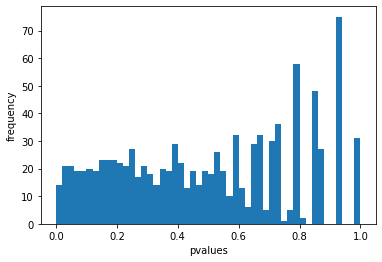

0.046

In [8]:
aa_test(df[(df.experimentVariant==1) & (df.version!='v2.8.0')].purchase, 
        df[(df.experimentVariant==0) & (df.version!='v2.8.0')].purchase)

Доля ложноположительных оценок (FPR) меньше 0,05.

Значит, изначально сплит-система работала неккоректно из-за работы версии приложения v2.8.0, и следует рассмотреть другие показатели для этой версии для уточнения причины поломки.